## From Marc Lelarge's [lecture notes](https://mlelarge.github.io/dataflowr-slides/Graphs/deep_graph.html)

### Task : semi-supervised clustering

Given a graph with two communities and a single node belonging to each community, retrieve the whole communities usin a graph neural network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# number of nodes
N = 120
# Barabasi-Albert parameter
m = 2
# for GNN
hidden_size = 5
# number of clusters to recover
num_classes = 2
# number of epochs
n_epochs = 50
# print log every x epochs
verbose = 5
# to plot clusters
colors = ['r', 'b']

In [3]:
# generate a random graph that bridges to clusters
G1 = nx.barabasi_albert_graph(N, 2)
G2 = nx.barabasi_albert_graph(N, 2)

# relabel nodes of G2
d = {}
for v in G1.nodes:
    d[v] = N+v
G2 = nx.relabel_nodes(G2, d)

G = nx.union(G1, G2)

G.add_edge(N-1, N)
# add some random weights on each edge
for _, _, d in G.edges(data=True):
    d['weight'] = np.random.rand()
    
# save layout
pos = nx.spring_layout(G)

G_dgl = dgl.DGLGraph(G)

### Message Passing Neural Network (MPNN)

See [Battaglia](https://arxiv.org/abs/1806.01261) for an overview of the current GNN architectures. 

Message passing networks are among the simplest. Each node carries a vector label, which is propagated at each step through its edges; this way, each node receives messages from its neighbours. These messages are then aggregated by adding them together to form the new labels. The function that generate the messages and the one that updates the labels are both neural networks with inputs the relevant vertices and edges, and therefore can be trained to minimize some objective loss.

After each step, the updated labels form a set of learned features that can be fed into another classification algorithm or another GNN layer for example.

In [4]:
# Define the message & reduce function
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)
    
# Define a 2-layer GCN model
class GCN(nn.Module):
    """ The first layer transforms input features of size of 2*N to a hidden layer.
    The second layer transforms the hidden layer and produces output features of 
    size corresponding to the number of groups.
    """
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h

### Training

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


Epoch 5 | Loss: 0.4607
Epoch 10 | Loss: 0.1931
Epoch 15 | Loss: 0.0540
Epoch 20 | Loss: 0.0138
Epoch 25 | Loss: 0.0044
Epoch 30 | Loss: 0.0019
Epoch 35 | Loss: 0.0010
Epoch 40 | Loss: 0.0007
Epoch 45 | Loss: 0.0005
Epoch 50 | Loss: 0.0004


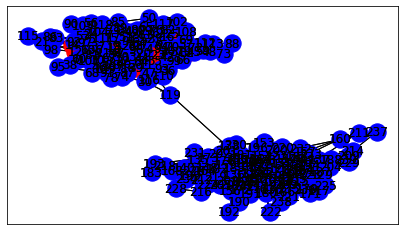

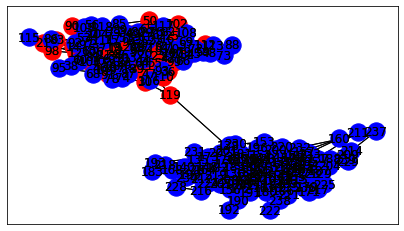

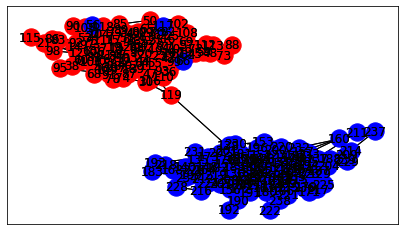

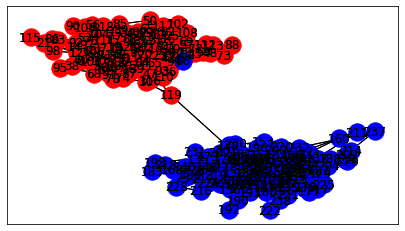

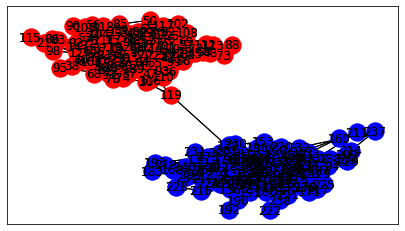

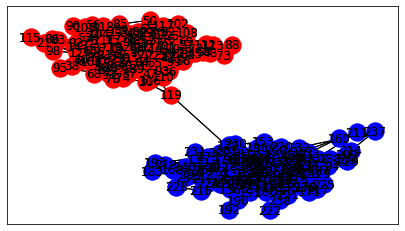

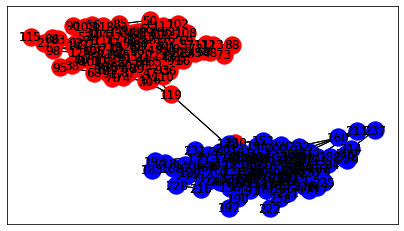

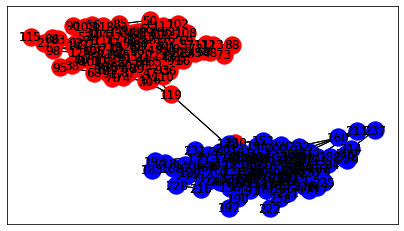

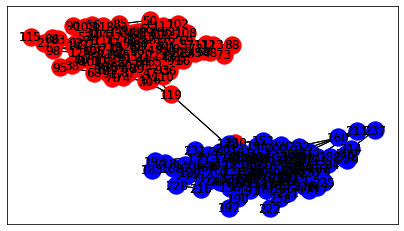

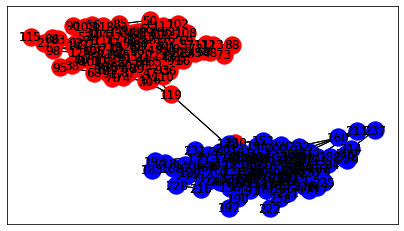

In [5]:
# Remark: in what follows, 2*N is simply the size of the graph (each community is of size N)

net = GCN(2*N, hidden_size, num_classes)

inputs = torch.eye(2*N) # one-hot vectors to initialize the node features i.e each node carries a label of size 2*N
labeled_nodes = torch.tensor([np.random.randint(N), np.random.randint(N, 2*N)])  # discover one label per clusters
labels = torch.tensor([0, 1])  # their labels are different
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(n_epochs):
    logits = net(G_dgl, inputs)
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # print loss and display the clustering to check on learning stage
    if (epoch+1)%verbose == 0:
        indices = torch.max(logp, dim=1).indices
        fig, ax = plt.subplots(figsize=(7,4), nrows=1, ncols=1)
        
        for color, label in zip(colors, labels):
            nodes = torch.where(indices==label)[0].tolist()
            nx.draw_networkx(G, 
                             pos=pos,
                             nodelist=nodes,
                             node_color=color,
                             ax=ax,
                            )
        print('Epoch %d | Loss: %.4f' % (epoch+1, loss.item()))